# Image Compression with K-Means

This notebook demonstrates **image compression using K-Means clustering** on an RGB image.

## Idea
An image of shape **(H, W, 3)** can be viewed as a dataset of **H·W pixels**, where each pixel is a point in **3D RGB space**:
\[
x = (R, G, B)
\]

K-Means is used to cluster these points into **K = 16** groups. The cluster centroids represent **16 “representative” colours** (a reduced palette).

## What compression means here
After training K-Means:
- each pixel is assigned to its **closest centroid**
- the pixel’s original colour is replaced by the centroid colour

This produces an image that uses only **16 colours**, while keeping the overall structure and appearance close to the original.

## Outputs
The notebook will:
1. Load an image and reshape it into a pixel dataset
2. Run K-Means to learn the 16 centroid colours
3. Reconstruct the compressed image using the learned palette
4. Visualize the palette and the RGB scatter plot with centroid markers


## 1) Imports

In [64]:
import numpy as np
import matplotlib.pyplot as plt

## 2) K-Means functions

- **`kMeans_init_centroids(X, K)`**: randomly selects **K** examples from `X` to serve as the **initial centroids** (starting palette).

- **`find_closest_centroids(X, centroids)`**: assigns each example (pixel) to the **nearest centroid**, returning `idx` (cluster index for every pixel).

- **`compute_centroids(X, idx, K)`**: recomputes each centroid as the **mean of all points assigned** to that cluster (updates the palette).

- **`run_kMeans(X, initial_centroids, max_iters, ...)`**: runs the K-Means loop for `max_iters` iterations:
  1) assignment step (`find_closest_centroids`)  
  2) update step (`compute_centroids`)  
  and returns the final `centroids` and `idx`.

In [65]:
def find_closest_centroids(X, centroids):
    """Computes the centroid memberships for every example.

    Args:
        X (ndarray): (m, n) Input values
        centroids (ndarray): (K, n) centroids

    Returns:
        idx (ndarray): (m,) index of closest centroid for each example
    """
    K = centroids.shape[0]
    idx = np.zeros(X.shape[0], dtype=int)

    for i in range(X.shape[0]):
        minima = float("inf")
        idx_i = -1
        for j in range(K):
            diff = X[i] - centroids[j]
            d = np.linalg.norm(diff)
            if d < minima:
                minima = d
                idx_i = j
        idx[i] = idx_i

    return idx


def compute_centroids(X, idx, K):
    """Returns the new centroids by computing the means of the data points assigned to each centroid.

    Args:
        X (ndarray):   (m, n) Data points
        idx (ndarray): (m,) index of closest centroid for each example
        K (int):       number of centroids

    Returns:
        centroids (ndarray): (K, n) new centroid positions
    """
    m, n = X.shape
    centroids = np.zeros((K, n))

    for k in range(K):
        points = X[idx == k]
        if points.shape[0] == 0:
            # Safety: if a cluster ends up empty, keep centroid unchanged by re-sampling a point
            centroids[k] = X[np.random.randint(0, m)]
        else:
            centroids[k] = np.mean(points, axis=0)

    return centroids


def kMeans_init_centroids(X, K):
    """Initializes K centroids to be used in K-Means on the dataset X.

    Strategy (as in the assignment): pick K random training examples without replacement.
    """
    randidx = np.random.permutation(X.shape[0])
    centroids = X[randidx[:K], :]
    return centroids


def run_kMeans(X, initial_centroids, max_iters, plot_progress=False):
    """Runs the K-Means algorithm on data matrix X.

    Args:
        X (ndarray): (m, n) data points
        initial_centroids (ndarray): (K, n) initial centroid positions
        max_iters (int): number of iterations
        plot_progress (bool): optional plotting hook (not needed for image compression)

    Returns:
        centroids (ndarray): (K, n) final centroid positions
        idx (ndarray): (m,) cluster assignment indices
    """
    m, n = X.shape
    centroids = initial_centroids
    idx = np.zeros(m, dtype=int)

    for i in range(max_iters):
        idx = find_closest_centroids(X, centroids)
        centroids = compute_centroids(X, idx, centroids.shape[0])

        if plot_progress:
            print(f"Iteration {i}/{max_iters-1}")

    return centroids, idx

## 3) Load image

Image shape: (251, 257, 3) dtype: float32 min/max: 0.0 1.0


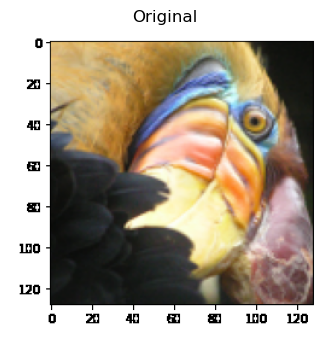

In [66]:
from pathlib import Path

img_path = Path("data/bird_small.png")  # change if needed

A = plt.imread(str(img_path))
# If you use a JPG later, you may need: A = A / 255.0

# Drop alpha channel if present
if A.ndim == 3 and A.shape[-1] == 4:
    A = A[..., :3]

print("Image shape:", A.shape, "dtype:", A.dtype, "min/max:", float(A.min()), float(A.max()))

plt.figure(figsize=(4,4))
plt.imshow(A)
plt.title("Original")
plt.axis("off")
plt.show()

## 4) Compress image with K=16 colours

1. Reshape image `(H, W, 3)` → `(H*W, 3)`  
2. Run K-Means  
3. Map each pixel to its centroid colour  
4. Reshape back to `(H, W, 3)`


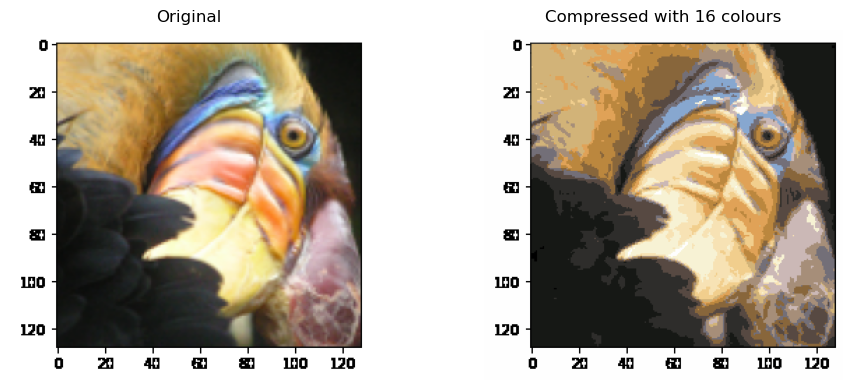

In [67]:
# Reshape image into an m x 3 matrix, where m = H*W
H, W, C = A.shape
X_img = A.reshape(-1, 3)

# Run K-Means on the pixel dataset
K = 16
max_iters = 10

initial_centroids = kMeans_init_centroids(X_img, K)
centroids, idx = run_kMeans(X_img, initial_centroids, max_iters, plot_progress=False)

# Recover the image from the centroid assignments
X_recovered = centroids[idx, :]
A_recovered = X_recovered.reshape(H, W, 3)

# Show results
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(A)
ax[0].set_title("Original")
ax[0].axis("off")

ax[1].imshow(A_recovered)
ax[1].set_title(f"Compressed with {K} colours")
ax[1].axis("off")

plt.tight_layout()
plt.show()


## 5) Show the learned 16-colour palette

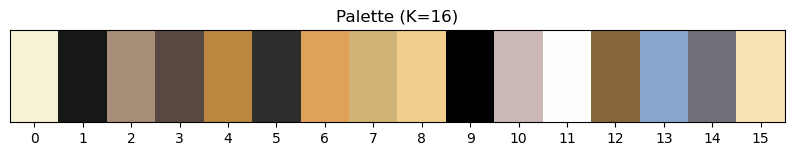

In [68]:
palette = centroids.reshape(1, K, 3)

plt.figure(figsize=(10, 1.2))
plt.imshow(palette, aspect="auto")
plt.yticks([])
plt.xticks(range(K), range(K))
plt.title(f"Palette (K={K})")
plt.show()


## 6) Original colors and their color clusters' centroids

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def plot_kMeans_RGB(X_img, centroids, idx, K, sample_size=10000):
    """
    3D RGB scatter of image pixels + centroid markers (red X).
    Works whether X_img is in [0,1] or [0,255].
    """
    X = X_img.copy()
    C = centroids.copy()

    # Ensure float
    X = X.astype(np.float32)
    C = C.astype(np.float32)

    # If data is normalized to [0,1], scale to [0,255] to match the common assignment plot axes
    if X.max() <= 1.0 and C.max() <= 1.0:
        X_plot = X * 255.0
        C_plot = C * 255.0
        colors = X  # for coloring scatter (matplotlib expects [0,1])
    else:
        X_plot = X
        C_plot = C
        colors = np.clip(X / 255.0, 0.0, 1.0)

    # Subsample for speed
    m = X_plot.shape[0]
    s = min(sample_size, m)
    samp = np.random.choice(m, size=s, replace=False)

    Xs = X_plot[samp]
    cols = colors[samp]

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")

    ax.scatter(Xs[:, 0], Xs[:, 1], Xs[:, 2], s=3, c=cols, depthshade=False)
    ax.scatter(C_plot[:, 0], C_plot[:, 1], C_plot[:, 2],
               s=200, c="red", marker="x", linewidths=3)

    ax.set_title("Original colors and their color clusters' centroids")
    ax.set_xlabel("R value - Redness")
    ax.set_ylabel("G value - Greenness")
    ax.set_zlabel("B value - Blueness")

    ax.set_xlim(0, 255)
    ax.set_ylim(0, 255)
    ax.set_zlim(0, 255)

    plt.tight_layout()
    plt.subplots_adjust(right=1)  # probaj 0.80–0.90 po potrebi
    plt.show()


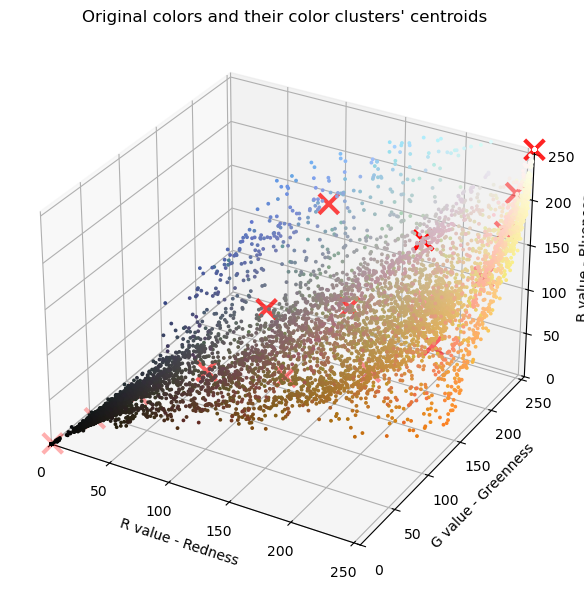

In [70]:
plot_kMeans_RGB(X_img, centroids, idx, K)